In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Part 1: EDA

In [2]:
with open('logins.json') as f:
    data = json.load(f)

In [3]:
logins = pd.DataFrame(data)

In [4]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins = logins.set_index('login_time').sort_index()

In [6]:
#Resample the data in 15-minute intervals and calculate the count of logins in each interval
login_counts = logins.resample('15T').size()

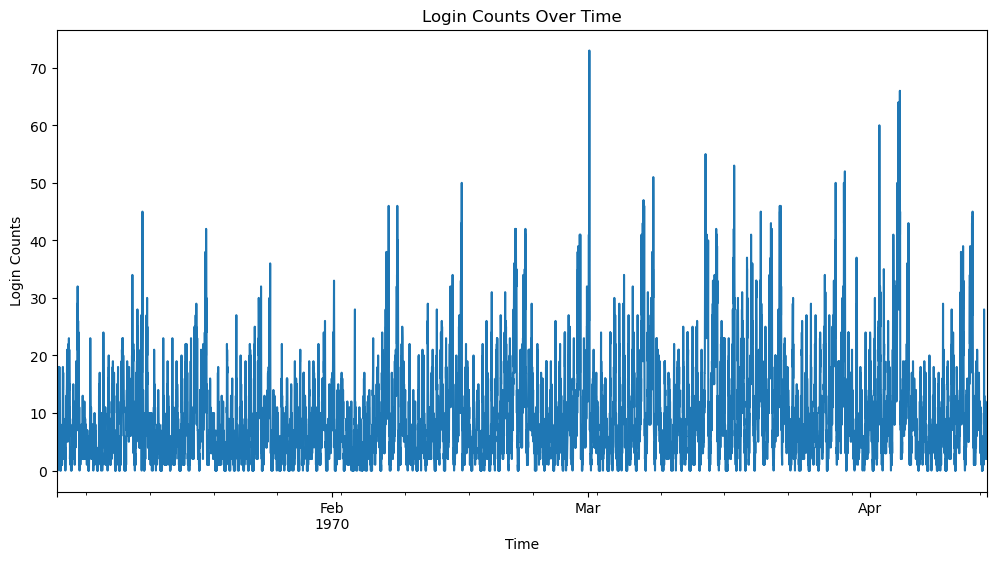

In [7]:
#visualize
plt.figure(figsize=(12, 6))
login_counts.plot()
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('Login Counts Over Time')
plt.show()

In [8]:
#Calculate daily login counts by resampling the data at a daily frequency:
daily_login_counts = login_counts.resample('D').sum()

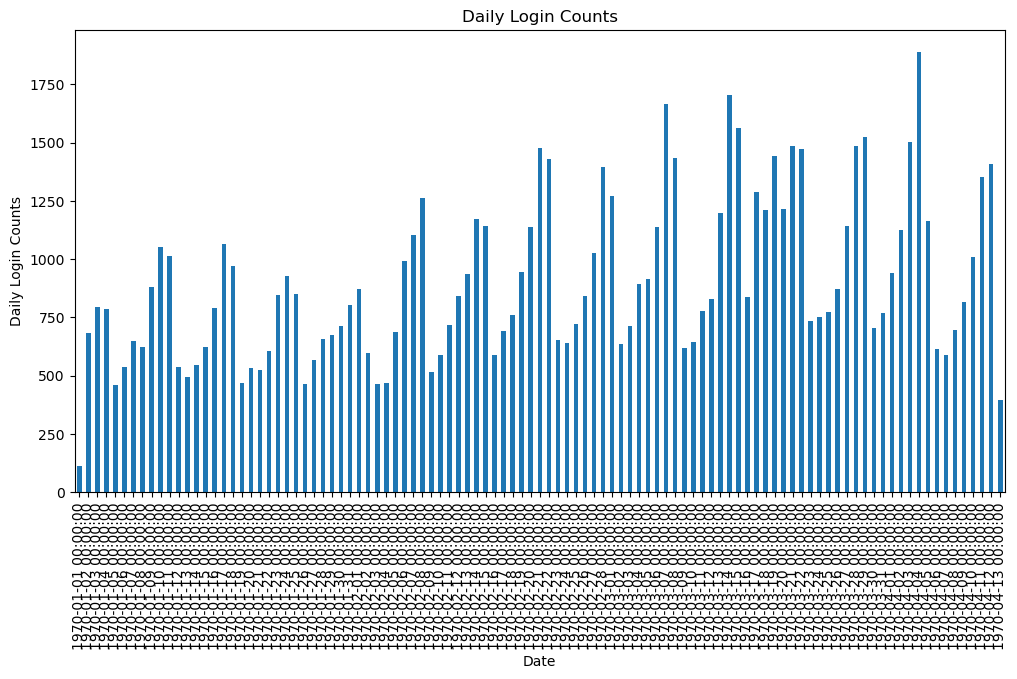

In [9]:
plt.figure(figsize=(12, 6))
daily_login_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Daily Login Counts')
plt.title('Daily Login Counts')
plt.show()

# Part 2 - Experiment and metrics design

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

There are no features of the dataframe that are great predictors of intercity travel. However to infer intercity travel I would use avg_dist and weekday_pct. My target would be to find the weekend avg_dist since it was noted that most tracel between cities occurred during the weekend. 

If each of the two days of the weekend (wknd_pct /2) have a greater avg_dist travel than the 5 days of the week (weekday_pct / 5) then it can be concluded that more travel between the two cities occur after the specified date that refunds were available.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

I would use hypothesis testing wherever the HO is: the weekend travel <= weekday and the HA is: weekend travel > weekday

b) what statistical test(s) you will conduct to verify the significance of the observation

I would use a one sided t-test and test for significance by the p-value 

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

caveats: if weekend travel proves to have a significant difference in distance between weekday travel is this due to intercity distance or due to more travel within the city since more customers may need rides


# Part 3 - Predictive modeling

In [10]:
with open('ultimate_data_challenge.json') as d:
    data = json.load(d)

In [11]:
df = pd.DataFrame(data)

In [12]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
#check for all missing values
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000
weekday_pct,0,0.000
avg_dist,0,0.000
avg_rating_by_driver,201,0.402


In [14]:
#replace avg_rating values with -1 replace phone with not-disclosed

df.loc[df['avg_rating_by_driver'].isnull(), 'avg_rating_by_driver'] = -1
df.loc[df['avg_rating_of_driver'].isnull(), 'avg_rating_of_driver'] = -1
df.loc[df['phone'].isnull(), 'phone'] = 'not disclosed'

In [15]:
#check the datatypes of the df 
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [16]:
#convert the objects that should be dates 
df['signup_date'] = pd.to_datetime(df['signup_date'])  
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [17]:
# when was data pulled? check by seeing the last_trip_date
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [18]:
#create a retained column that determines if a trip was made in the last 30 days 
cutoff_date = pd.to_datetime('2014-07-01 00:00:00')

df['retained'] = (df['last_trip_date'] >= cutoff_date - pd.Timedelta(days=30)).astype(int)

Exploratory Data Analysis

In [19]:
#EDA with ydata profiling 

#from ydata_profiling import ProfileReport

#profile = ProfileReport(df)
#profile.to_file("data_profile2.html")

<img src="last_trip_info.png">

<img src='last_trip_2.png'>

In [20]:
#what is the count of retained per value
df['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

heatmap

<img src='heatmap_2.png'>

The weekend_pct and city have the most correlation with the retained column. Also avg_surge and surge_pct are very similar and may display collinearity

Modeling

Decide on the model... 
1) classification model 
2) since the data is imbalanced retained has 31,196 negative/ 0 values and 18804 positive/ 1 values - boosting model 

In [21]:
X= df[['city', 'trips_in_first_30_days','avg_rating_of_driver', 'avg_surge',
       'phone','surge_pct','ultimate_black_user', 'weekday_pct', 'avg_dist','avg_rating_by_driver']]
y= df['retained']

In [22]:
X= pd.get_dummies(X)
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_not disclosed
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,0,1,0,0,1,0
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,1,0,0,0,1,0
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,0,1,0,0,1,0
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, train_test_split

In [24]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LightGBM classifier
gb_model = GradientBoostingClassifier()

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_test)
accuracy = (val_predictions == y_test).sum() / len(y_test)
print("Validation Accuracy: ", accuracy)


Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Best Accuracy Score:  0.7920500209895378
Validation Accuracy:  0.7859
